In [1]:
from copy import deepcopy
import math
import matplotlib.pyplot as plt
import molmass
import pandas as pd
from pathlib import Path
from rdkit import Chem, DataStructs, Geometry
from rdkit.ML.Cluster import Butina
from rdkit.Chem import AllChem, rdFingerprintGenerator, rdFMCS, rdMolDescriptors
from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [3]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [4]:
def intra_tanimoto(fps_clusters):
    """Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    # Calculate intra similarity per cluster
    for cluster in fps_clusters:
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    return intra_similarity

In [5]:
def highlight_molecules(molecules, mcs, number, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = deepcopy(molecules)
    # convert MCS to molecule
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    # find the matching atoms in each molecule
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    # Align by matched substructure so they are depicted in the same orientation
    # Adapted from: https://gist.github.com/greglandrum/82d9a86acb3b00d3bb1df502779a5810
    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Chem.Draw.MolsToGridImage(
        molecules[:number],
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )

In [6]:
def highlight_molecules(molecules, mcs, number, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = deepcopy(molecules)
    # convert MCS to molecule
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    # find the matching atoms in each molecule
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    # Align by matched substructure so they are depicted in the same orientation
    # Adapted from: https://gist.github.com/greglandrum/82d9a86acb3b00d3bb1df502779a5810
    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Chem.Draw.MolsToGridImage(
        molecules[:number],
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )

In [7]:
def mcs(clusternum):
    """Finds the maximum common structure for all molecules contained in a cluster"""
    mols = []
    for i in clusters[clusternum]:
        mols.append(compounds[i][0])
    mcs1 = rdFMCS.FindMCS(mols)
    m1 = Chem.MolFromSmarts(mcs1.smartsString)
    x = display(Chem.Draw.MolToImage(m1, legend='MCS'))
    return x

In [1]:
def logsconv(molefraction, smilestring):
    """Converts mole fraction to LogS"""
    mol = Chem.MolFromSmiles(smilestring)
    formula = rdMolDescriptors.CalcMolFormula(mol)
    molarmass = molmass.Formula(formula).mass
    molarmasskg = molarmass * 0.001
    molfractsolute = molefraction
    molfractsolvent = 1 - molfractsolute
    h20density = 997 #density of water at room temp in Kilogram per Cubic Meter
    h20mass = 0.01801528 #molar mass of water at room temp in kg
    sval = ((molfractsolute*h20density*0.001)/(molfractsolvent*h20mass+molfractsolute*molarmasskg))
    logsval = math.log10(sval)
    return(logsval)

In [9]:
def addtodct(clusterindex):
    """Creates a directory containing each solute and it's solubilities for 5 solvents"""
    mol1df = solrangedf.copy()
    count = 0
    for i in mol1df['SMILES']:
        if i not in newclsuterlstsmiles[clusterindex]:
            mol1df = mol1df.drop(mol1df.index[count])
            count -= 1
        count += 1
    mol1df = mol1df.drop_duplicates(subset=["Solvent"], keep='first')
    logslst = mol1df['LogS'].tolist()
    smileslst38 = list(set(mol1df['SMILES'].tolist()))
    dictforsol1[smileslst38[0]] = logslst

In [10]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

## Condensing BigSolDB to Single Temperature
303.15 K is the temperature with the most solute data in BigSolDB

In [11]:
df = pd.read_csv('BigSolDB.csv')
display(df)

,SMILES,"T,K",Solubility,Solvent,SMILES_Solvent,Source
0,ON(Cc1ccccc1)Cc1ccccc1,273.15,0.001261,methanol,CO,10.1021/acs.jced.9b01028
1,ON(Cc1ccccc1)Cc1ccccc1,279.15,0.001713,methanol,CO,10.1021/acs.jced.9b01028
2,ON(Cc1ccccc1)Cc1ccccc1,283.45,0.002094,methanol,CO,10.1021/acs.jced.9b01028
3,ON(Cc1ccccc1)Cc1ccccc1,289.05,0.002760,methanol,CO,10.1021/acs.jced.9b01028
4,ON(Cc1ccccc1)Cc1ccccc1,293.05,0.003327,methanol,CO,10.1021/acs.jced.9b01028
...,...,...,...,...,...,...
54268,COC(=O)C1CC(=O)C(C(=O)OC)CC1=O,314.65,0.016360,DMS,COC(=O)CCC(=O)OC,10.1016/j.fluid.2014.04.012
54269,COC(=O)C1CC(=O)C(C(=O)OC)CC1=O,318.05,0.018920,DMS,COC(=O)CCC(=O)OC,10.1016/j.fluid.2014.04.012
54270,COC(=O)C1CC(=O)C(C(=O)OC)CC1=O,320.65,0.021050,DMS,COC(=O)CCC(=O)OC,10.1016/j.fluid.2014.04.012
54271,COC(=O)C1CC(=O)C(C(=O)OC)CC1=O,323.25,0.023430,DMS,COC(=O)CCC(=O)OC,10.1016/j.fluid.2014.04.012


In [12]:
templst = []
for i in df['T,K']:
    templst.append(i)
utemplst = list(set(templst))
utemplst.sort()
tempdct = {}
for i in utemplst:
    tempdct['%s' % i] = templst.count(i)
sortedtempdct = sorted(tempdct.items(), key=lambda item: item[1], reverse=True)
print(sortedtempdct[0])
# 4192 molecules with solubility data at 303.15 K

('303.15', 4192)


Here we are saving BigSolDB as a df containing solute data at only 303.15 K

In [13]:
# df30315 = df.copy()
# temp = df30315['T,K']
# count = 0
# for i in temp:
#     if i != 303.15:
#         df30315 = df30315.drop(df30315.index[count])
#         count -= 1
#     count += 1
# display(df30315)
# df30315.to_csv('df30315.csv', index=False)

## Selecting Which Solvents to Use

Solvents chosen out of intuition: ethanol, n-butanol, ethyl acetate, acetonitrile, isopropanol  
Solvents with most molecules : ethanol, methanol, isoppropanol, ethyl acetate, n-propanol  
  
Will choose intuitive chosen solvents due to range of polarity

In [14]:
df30315 = pd.read_csv('df30315.csv')
display(df30315)

,SMILES,"T,K",Solubility,Solvent,SMILES_Solvent,Source
0,COC(=O)[C@@H](N)CS.Cl,303.15,0.126800,methanol,CO,10.1021/acs.jced.0c00795
1,CC1(C)NC(=O)NC1=O,303.15,0.099320,methanol,CO,10.1021/acs.jced.9b01020
2,NS(=O)(=O)Cc1noc2ccccc12,303.15,0.004211,methanol,CO,10.1021/acs.jced.0c00249
3,CC(=O)Oc1ccccc1C(=O)Nc1ncc([N+](=O)[O-])s1,303.15,0.000261,methanol,CO,10.1021/acs.jced.0c00254
4,O=Cc1cc(Br)c(O)c(Br)c1,303.15,0.003954,methanol,CO,10.1021/acs.jced.0c00376
...,...,...,...,...,...,...
4187,Nc1cc(Cl)ccc1C(=O)O,303.15,0.000418,ethyl benzene,CCc1ccccc1,10.1016/j.jct.2016.11.019
4188,COc1cc(Cl)nc(N)n1,303.15,0.002385,ethyl benzene,CCc1ccccc1,10.1016/j.jct.2016.10.020
4189,O=C(NC[C@H]1CN(c2ccc(N3CCOCC3=O)cc2)C(=O)O1)c1...,303.15,0.000063,2-hexanone,CCCCC(C)=O,10.1016/j.jct.2016.09.036
4190,NCCCC(=O)O,303.15,0.009136,"1,3-propanediol",OCCCO,10.1016/j.jct.2016.07.014


In [15]:
solvlst30315 = []
for i in df30315['Solvent']:
    solvlst30315.append(i)
usolvlst30315 = list(set(solvlst30315))
usolvlst30315.sort()

In [16]:
solvdct30315 = {}
for i in usolvlst30315:
    solvdct30315['%s' % i] = solvlst30315.count(i)
display(solvdct30315)

{'1,1-dichloroethane': 1,
 '1,2-dichlorobenzene': 1,
 '1,2-dichloroethane': 12,
 '1,2-diethoxyethane': 1,
 '1,3-propanediol': 1,
 '1,4-dioxane': 133,
 '1-methoxy-2-propanol': 3,
 '1-methoxy-2-propyl acetate': 3,
 '1-propoxy-2-propanol': 3,
 '2-(2-methoxypropoxy) propanol': 3,
 '2-butanone': 67,
 '2-butoxyethanol': 2,
 '2-ethoxyethanol': 9,
 '2-ethyl-n-hexanol': 1,
 '2-hexanone': 1,
 '2-methoxyethanol': 9,
 '2-methyltetrahydrofuran': 1,
 '2-pentanol': 2,
 '2-pentanone': 1,
 '2-propoxyethanol': 5,
 '3-pentanone': 1,
 'DMAc': 12,
 'DMF': 138,
 'DMSO': 50,
 'MIBK': 1,
 'MTBE': 9,
 'N,N-dimethylaniline': 1,
 'NMP': 51,
 'PEG-400': 4,
 'THF': 50,
 'acetic acid': 28,
 'acetone': 261,
 'acetonitrile': 237,
 'acetophenone': 3,
 'acetylacetone': 3,
 'acrylic acid': 2,
 'anisole': 2,
 'benzene': 10,
 'benzyl alcohol': 2,
 'benzylalcohol': 1,
 'chlorobenzene': 3,
 'chloroform': 28,
 'cumene': 1,
 'cyclohexane': 66,
 'cyclohexanone': 20,
 'cyclopentanone': 1,
 'diacetone alcohol': 1,
 'dichlorometh

In [17]:
sortedsolvdct30315 = sorted(solvdct30315.items(), key=lambda item: item[1], reverse=True)
print(sortedsolvdct30315[0:10])

[('ethanol', 423), ('methanol', 355), ('isopropanol', 327), ('ethyl acetate', 301), ('n-propanol', 277), ('acetone', 261), ('n-butanol', 249), ('acetonitrile', 237), ('water', 234), ('DMF', 138)]


## Clustering Molecules

TeachOpenCADD T005 Compound Clustering Tutorial applied to BigSolDB containg solubility data at 303.15K

In [18]:
compound_df = pd.read_csv("df30315.csv")
print("Dataframe shape:", compound_df.shape)
compound_df.head()

Dataframe shape: (4192, 6)


,SMILES,"T,K",Solubility,Solvent,SMILES_Solvent,Source
0,COC(=O)[C@@H](N)CS.Cl,303.15,0.126800,methanol,CO,10.1021/acs.jced.0c00795
1,CC1(C)NC(=O)NC1=O,303.15,0.099320,methanol,CO,10.1021/acs.jced.9b01020
2,NS(=O)(=O)Cc1noc2ccccc12,303.15,0.004211,methanol,CO,10.1021/acs.jced.0c00249
3,CC(=O)Oc1ccccc1C(=O)Nc1ncc([N+](=O)[O-])s1,303.15,0.000261,methanol,CO,10.1021/acs.jced.0c00254
4,O=Cc1cc(Br)c(O)c(Br)c1,303.15,0.003954,methanol,CO,10.1021/acs.jced.0c00376


In [19]:
compound_df.drop_duplicates(subset=['SMILES'], inplace=True)

In [20]:
compounds = []
for _, smiles2, smiles in compound_df[["SMILES", "SMILES"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), smiles2))
compounds[:5]

[(<rdkit.Chem.rdchem.Mol at 0x7fbe78de8820>, 'COC(=O)[C@@H](N)CS.Cl'),
 (<rdkit.Chem.rdchem.Mol at 0x7fbe78de89e0>, 'CC1(C)NC(=O)NC1=O'),
 (<rdkit.Chem.rdchem.Mol at 0x7fbe78de8900>, 'NS(=O)(=O)Cc1noc2ccccc12'),
 (<rdkit.Chem.rdchem.Mol at 0x7fbe78de8a50>,
  'CC(=O)Oc1ccccc1C(=O)Nc1ncc([N+](=O)[O-])s1'),
 (<rdkit.Chem.rdchem.Mol at 0x7fbe78de8ac0>, 'O=Cc1cc(Br)c(O)c(Br)c1')]

In [21]:
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in compounds]

print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))
# NBVAL_CHECK_OUTPUT

Number of compounds converted: 583
Fingerprint length per compound: 2048


In [22]:
# for cutoff in numpy.arange(0.0, 1.0, 0.2):
#     clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
#     fig, ax = plt.subplots(figsize=(15, 4))
#     ax.set_title(f"Threshold: {cutoff:3.1f}")
#     ax.set_xlabel("Cluster index")
#     ax.set_ylabel("Number of molecules")
#     ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
#     display(fig)

Number of clusters: 220 from 583 molecules at distance cut-off 0.60
Number of molecules in largest cluster: 54
Similarity between two random points in same cluster: 0.41
Similarity between two random points in different cluster: 0.33


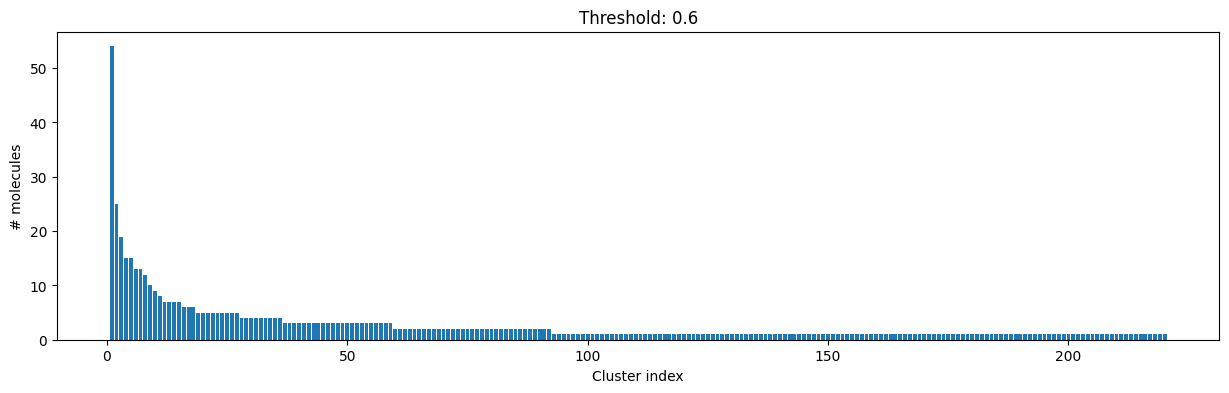

In [23]:
cutoff = 0.6
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)

fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters])
ax.set_title(f"Threshold: {cutoff:3.1f}")

print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} molecules at distance cut-off {cutoff:.2f}"
)
print("Number of molecules in largest cluster:", len(clusters[0]))
print(
    f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}"
)
print(
    f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]):.2f}"
)

Ten molecules from largest cluster:


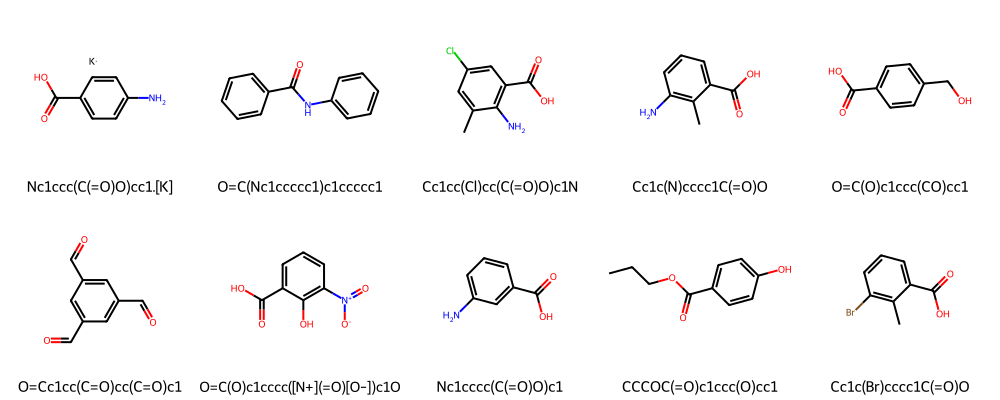

In [24]:
print("Ten molecules from largest cluster:")
Chem.Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[0][:10]],
    legends=[compounds[i][1] for i in clusters[0][:10]],
    molsPerRow=5,
)

Ten molecules from 2nd largest cluster:


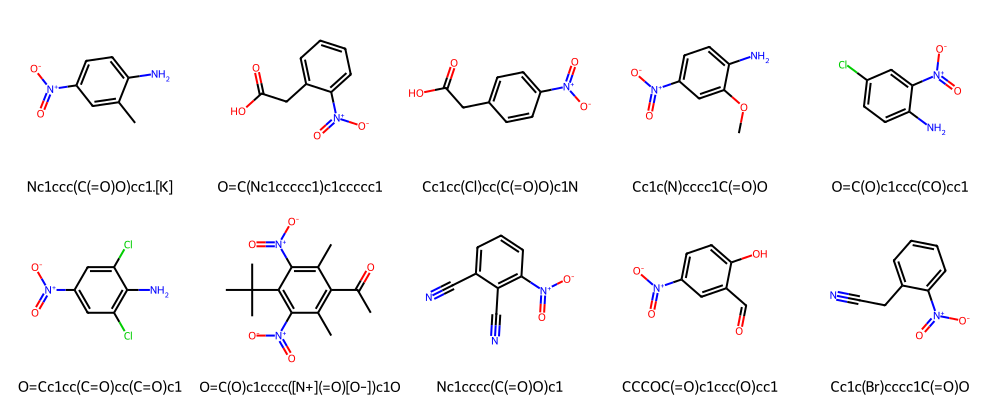

In [25]:
print("Ten molecules from 2nd largest cluster:")
Chem.Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[1][:10]],
    legends=[compounds[i][1] for i in clusters[0][:10]],
    molsPerRow=5,
)

In [26]:
cluster1 = []
for i in clusters[0]:
    cluster1.append(compounds[i][1])
print(len(cluster1))
print(cluster1)
#places all compounds in a cluster into a list of smiles

54
['Nc1ccc(C(=O)O)cc1.[K]', 'O=C(Nc1ccccc1)c1ccccc1', 'Cc1cc(Cl)cc(C(=O)O)c1N', 'Cc1c(N)cccc1C(=O)O', 'O=C(O)c1ccc(CO)cc1', 'O=Cc1cc(C=O)cc(C=O)c1', 'O=C(O)c1cccc([N+](=O)[O-])c1O', 'Nc1cccc(C(=O)O)c1', 'CCCOC(=O)c1ccc(O)cc1', 'Cc1c(Br)cccc1C(=O)O', 'COC(=O)c1ccc(C(=O)OC)cc1', 'Cc1cccc(C(=O)O)c1N', 'NC(=O)c1ccc(N)cc1', 'O=C(O)c1cc2ccccc2cc1O', 'O=C(O)c1c(O)cccc1O', 'COc1cc(C(=O)O)cc(OC)c1O', 'CC(C)(C)c1ccc(C(=O)O)cc1', 'CC(=O)c1cccc([N+](=O)[O-])c1', 'CC(=O)c1ccc([N+](=O)[O-])cc1', 'O=C(O)c1ccccc1O', 'CCOC(=O)c1ccc(N)cc1', 'O=Cc1ccc2ccccc2c1', 'Nc1ccc(Cc2ccc(N)cc2)cc1', 'O=C(O)c1ccc(O)c(O)c1', 'Nc1ccc(O)c(C(=O)O)c1', 'O=C(Oc1ccccc1)c1ccccc1O', 'O=Cc1ccc(C(=O)O)cc1', 'CC(=O)Nc1ccc(C(=O)O)cc1', 'O=Cc1cccc([N+](=O)[O-])c1', 'O=Cc1ccc([N+](=O)[O-])cc1', 'Cc1cc(C(=O)O)ccc1[N+](=O)[O-]', 'O=C(O)c1cccc(O)c1O', 'Nc1cccc(Cl)c1C(=O)O', 'Cc1c(C(=O)O)cc([N+](=O)[O-])cc1[N+](=O)[O-]', 'NC(=O)c1ccc([N+](=O)[O-])cc1', 'COc1cc(C(=O)O)ccc1O', 'COc1ccc(C(=O)O)c(OC)c1', 'COc1cc(OC)cc(C(=O)O)c1', 'N#Cc1c

## Finding Maximum Common Substructures

In [27]:
mols = []
for i in clusters[0]:
    mols.append(compounds[i][0])

In [28]:
mcs1 = rdFMCS.FindMCS(mols)
print(f"MCS1 contains {mcs1.numAtoms} atoms and {mcs1.numBonds} bonds.")
print("MCS SMARTS string:", mcs1.smartsString)
# NBVAL_CHECK_OUTPUT

MCS1 contains 7 atoms and 7 bonds.
MCS SMARTS string: [#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1


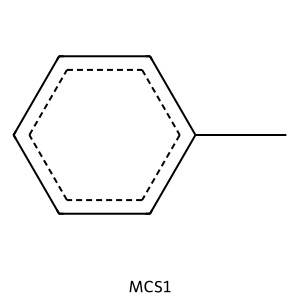

In [29]:
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Chem.Draw.MolToImage(m1, legend="MCS1")

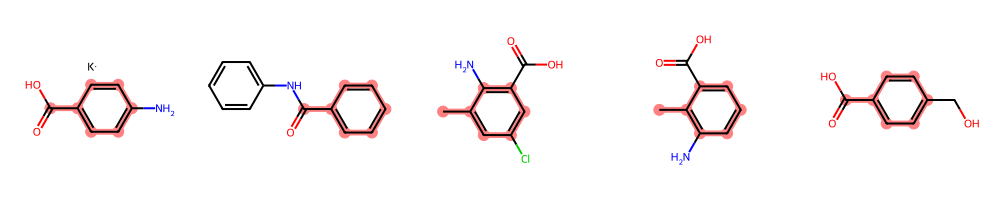

In [30]:
highlight_molecules(mols, mcs1, 5)

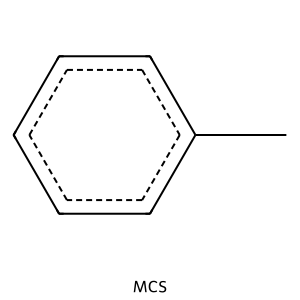

In [31]:
#to look at mcs for other clusters

mcs(0)

## Choosing which molecules from each cluster to use

In [32]:
top5solvlst = ['ethanol', 'n-butanol', 'ethyl acetate', 'acetonitrile', 'isopropanol']

In [33]:
#looks at how many molecules are in each cluster for the 20 largest clusters

sum = 0
for i in range(20):
    cluster1 = []
    for j in clusters[i]:
        cluster1.append(compounds[i][1])
    print('cluster', str(i+1)+':', len(cluster1))
    sum += len(cluster1)
print('total'+':', sum)

cluster 1: 54
cluster 2: 25
cluster 3: 19
cluster 4: 15
cluster 5: 15
cluster 6: 13
cluster 7: 13
cluster 8: 12
cluster 9: 10
cluster 10: 9
cluster 11: 8
cluster 12: 7
cluster 13: 7
cluster 14: 7
cluster 15: 7
cluster 16: 6
cluster 17: 6
cluster 18: 6
cluster 19: 5
cluster 20: 5
total: 249


In [34]:
#creates a new list containing all molecules in each cluster
cluster1 = []
for i in clusters[0]:
    cluster1.append(compounds[i][1])
print(len(cluster1))
print(cluster1)

54
['Nc1ccc(C(=O)O)cc1.[K]', 'O=C(Nc1ccccc1)c1ccccc1', 'Cc1cc(Cl)cc(C(=O)O)c1N', 'Cc1c(N)cccc1C(=O)O', 'O=C(O)c1ccc(CO)cc1', 'O=Cc1cc(C=O)cc(C=O)c1', 'O=C(O)c1cccc([N+](=O)[O-])c1O', 'Nc1cccc(C(=O)O)c1', 'CCCOC(=O)c1ccc(O)cc1', 'Cc1c(Br)cccc1C(=O)O', 'COC(=O)c1ccc(C(=O)OC)cc1', 'Cc1cccc(C(=O)O)c1N', 'NC(=O)c1ccc(N)cc1', 'O=C(O)c1cc2ccccc2cc1O', 'O=C(O)c1c(O)cccc1O', 'COc1cc(C(=O)O)cc(OC)c1O', 'CC(C)(C)c1ccc(C(=O)O)cc1', 'CC(=O)c1cccc([N+](=O)[O-])c1', 'CC(=O)c1ccc([N+](=O)[O-])cc1', 'O=C(O)c1ccccc1O', 'CCOC(=O)c1ccc(N)cc1', 'O=Cc1ccc2ccccc2c1', 'Nc1ccc(Cc2ccc(N)cc2)cc1', 'O=C(O)c1ccc(O)c(O)c1', 'Nc1ccc(O)c(C(=O)O)c1', 'O=C(Oc1ccccc1)c1ccccc1O', 'O=Cc1ccc(C(=O)O)cc1', 'CC(=O)Nc1ccc(C(=O)O)cc1', 'O=Cc1cccc([N+](=O)[O-])c1', 'O=Cc1ccc([N+](=O)[O-])cc1', 'Cc1cc(C(=O)O)ccc1[N+](=O)[O-]', 'O=C(O)c1cccc(O)c1O', 'Nc1cccc(Cl)c1C(=O)O', 'Cc1c(C(=O)O)cc([N+](=O)[O-])cc1[N+](=O)[O-]', 'NC(=O)c1ccc([N+](=O)[O-])cc1', 'COc1cc(C(=O)O)ccc1O', 'COc1ccc(C(=O)O)c(OC)c1', 'COc1cc(OC)cc(C(=O)O)c1', 'N#Cc1c

In [149]:
clsuterlstsmiles = ['O=Cc1cc(Br)c(O)c(Br)c1', 'Cc1cc(C(=O)O)ccc1[N+](=O)[O-]', 'Oc1ccc(OCc2ccccc2)cc1', 'Nc1ccc(S(=O)(=O)Nc2ccc(Cl)nn2)cc1', 'CC(=O)O[C@]1(C(C)=O)CC[C@H]2[C@@H]3C=C(Cl)C4=CC(=O)[C@@H]5C[C@@H]5[C@]4(C)[C@H]3CC[C@@]21C', 'C=C1C[C@]23C[C@H]1CC[C@H]2[C@@]12CC[C@H](O)[C@@](C)(C(=O)O1)[C@H]2[C@@H]3C(=O)O', 'N#CCc1ccc([N+](=O)[O-])cc1', 'O=C(O)c1cc([N+](=O)[O-])cc([N+](=O)[O-])c1O', 'N#Cc1cccc([N+](=O)[O-])c1', 'CC(=O)N[C@@H](CC(C)C)C(=O)O', 'CC(=O)N[C@@H](CC(C)C)C(=O)O', 'N[C@@H](CO)C(=O)O', 'COc1cc([N+](=O)[O-])ccc1N', 'Nc1c(Cl)cc([N+](=O)[O-])cc1Cl', 'CC(=O)Nc1ccccc1[N+](=O)[O-]', 'N[C@H](Cc1c[nH]c2ccccc12)C(=O)O', 'Cl.N[C@@H](Cc1ccccc1)C(=O)OCc1ccccc1', 'CC(=O)N1CCC[C@H]1C(=O)O', 'CSCCC(NC(C)=O)C(=O)O', 'CCOC(=O)[C@@H]1CSCN1.Cl', 'OC[C@H]1O[C@@H](Oc2ccc(O)cc2)[C@H](O)[C@@H](O)[C@@H]1O', 'OCc1ccccc1O[C@@H]1OC(CO)[C@@H](O)[C@@H](O)C1O', 'CC(=O)Nc1ccc(OC(=O)c2ccccc2OC(C)=O)cc1', 'COc1ccc(CN2CCNCC2)c(OC)c1OC.Cl', 'CC(=O)Oc1ccccc1C(=O)Nc1ncc([N+](=O)[O-])s1', 'COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC3)c12', 'CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn4c3c2OCN4C)CC1']

In [37]:
# removing salts from cluster list

newclsuterlstsmiles = []
for solute in clsuterlstsmiles:
    if '.' not in solute:
        newclsuterlstsmiles.append(solute)

In [38]:
solrangedf = df30315.copy()
display(solrangedf)

,SMILES,"T,K",Solubility,Solvent,SMILES_Solvent,Source
0,COC(=O)[C@@H](N)CS.Cl,303.15,0.126800,methanol,CO,10.1021/acs.jced.0c00795
1,CC1(C)NC(=O)NC1=O,303.15,0.099320,methanol,CO,10.1021/acs.jced.9b01020
2,NS(=O)(=O)Cc1noc2ccccc12,303.15,0.004211,methanol,CO,10.1021/acs.jced.0c00249
3,CC(=O)Oc1ccccc1C(=O)Nc1ncc([N+](=O)[O-])s1,303.15,0.000261,methanol,CO,10.1021/acs.jced.0c00254
4,O=Cc1cc(Br)c(O)c(Br)c1,303.15,0.003954,methanol,CO,10.1021/acs.jced.0c00376
...,...,...,...,...,...,...
4187,Nc1cc(Cl)ccc1C(=O)O,303.15,0.000418,ethyl benzene,CCc1ccccc1,10.1016/j.jct.2016.11.019
4188,COc1cc(Cl)nc(N)n1,303.15,0.002385,ethyl benzene,CCc1ccccc1,10.1016/j.jct.2016.10.020
4189,O=C(NC[C@H]1CN(c2ccc(N3CCOCC3=O)cc2)C(=O)O1)c1...,303.15,0.000063,2-hexanone,CCCCC(C)=O,10.1016/j.jct.2016.09.036
4190,NCCCC(=O)O,303.15,0.009136,"1,3-propanediol",OCCCO,10.1016/j.jct.2016.07.014


In [39]:
count = 0
for i in solrangedf['Solvent']:
    if i not in top5solvlst:
        solrangedf = solrangedf.drop(solrangedf.index[count])
        count -= 1
    count += 1
count = 0
for i in solrangedf['SMILES']:
    if i not in newclsuterlstsmiles:
        solrangedf = solrangedf.drop(solrangedf.index[count])
        count -= 1
    count += 1

In [40]:
solubilitylst = []
logslst = []
for i in solrangedf['Solubility']:
    solubilitylst.append(i)
smileslst = []
for i in solrangedf['SMILES']:
    smileslst.append(i)
for i,j in zip(solubilitylst, smileslst):
    logslst.append(logsconv(i,j))
print(len(logslst))
solrangedf['LogS'] = logslst
display(solrangedf)

136


,SMILES,"T,K",Solubility,Solvent,SMILES_Solvent,Source,LogS
358,CC(=O)Oc1ccccc1C(=O)Nc1ncc([N+](=O)[O-])s1,303.15,0.000331,ethanol,CCO,10.1021/acs.jced.0c00254,-1.739420
359,O=Cc1cc(Br)c(O)c(Br)c1,303.15,0.005547,ethanol,CCO,10.1021/acs.jced.0c00376,-0.546569
360,CC(=O)Nc1ccc(OC(=O)c2ccccc2OC(C)=O)cc1,303.15,0.000486,ethanol,CCO,10.1021/acs.jced.0c00301,-1.573756
372,CC(=O)Nc1ccccc1[N+](=O)[O-],303.15,0.032350,ethanol,CCO,10.1021/acs.jced.1c00037,0.141947
373,CSCCC(NC(C)=O)C(=O)O,303.15,0.095400,ethanol,CCO,10.1021/acs.jced.1c00064,0.439900
...,...,...,...,...,...,...,...
2372,N#CCc1ccc([N+](=O)[O-])cc1,303.15,0.003321,isopropanol,CC(C)O,10.1021/acs.jced.9b00005,-0.747065
2381,N#Cc1cccc([N+](=O)[O-])c1,303.15,0.005649,isopropanol,CC(C)O,10.1021/acs.jced.8b00230,-0.522340
2390,CC(=O)Nc1ccc(OC(=O)c2ccccc2OC(C)=O)cc1,303.15,0.000604,isopropanol,CC(C)O,10.1016/j.jct.2021.106517,-1.479974
2406,N[C@H](Cc1c[nH]c2ccccc12)C(=O)O,303.15,0.000026,isopropanol,CC(C)O,10.1016/j.jct.2018.08.018,-2.835789


In [41]:
display(solrangedf)

,SMILES,"T,K",Solubility,Solvent,SMILES_Solvent,Source,LogS
358,CC(=O)Oc1ccccc1C(=O)Nc1ncc([N+](=O)[O-])s1,303.15,0.000331,ethanol,CCO,10.1021/acs.jced.0c00254,-1.739420
359,O=Cc1cc(Br)c(O)c(Br)c1,303.15,0.005547,ethanol,CCO,10.1021/acs.jced.0c00376,-0.546569
360,CC(=O)Nc1ccc(OC(=O)c2ccccc2OC(C)=O)cc1,303.15,0.000486,ethanol,CCO,10.1021/acs.jced.0c00301,-1.573756
372,CC(=O)Nc1ccccc1[N+](=O)[O-],303.15,0.032350,ethanol,CCO,10.1021/acs.jced.1c00037,0.141947
373,CSCCC(NC(C)=O)C(=O)O,303.15,0.095400,ethanol,CCO,10.1021/acs.jced.1c00064,0.439900
...,...,...,...,...,...,...,...
2372,N#CCc1ccc([N+](=O)[O-])cc1,303.15,0.003321,isopropanol,CC(C)O,10.1021/acs.jced.9b00005,-0.747065
2381,N#Cc1cccc([N+](=O)[O-])c1,303.15,0.005649,isopropanol,CC(C)O,10.1021/acs.jced.8b00230,-0.522340
2390,CC(=O)Nc1ccc(OC(=O)c2ccccc2OC(C)=O)cc1,303.15,0.000604,isopropanol,CC(C)O,10.1016/j.jct.2021.106517,-1.479974
2406,N[C@H](Cc1c[nH]c2ccccc12)C(=O)O,303.15,0.000026,isopropanol,CC(C)O,10.1016/j.jct.2018.08.018,-2.835789


In [42]:
mol1df = solrangedf.copy()
count = 0
for i in mol1df['SMILES']:
    if i not in newclsuterlstsmiles[1]:
        mol1df = mol1df.drop(mol1df.index[count])
        count -= 1
    count += 1
mol1df = mol1df.drop_duplicates(subset=["Solvent"], keep='first')
display(mol1df)

,SMILES,"T,K",Solubility,Solvent,SMILES_Solvent,Source,LogS
738,Cc1cc(C(=O)O)ccc1[N+](=O)[O-],303.15,0.011300,ethanol,CCO,10.1016/j.jct.2016.07.023,-0.246176
1282,Cc1cc(C(=O)O)ccc1[N+](=O)[O-],303.15,0.012490,n-butanol,CCCCO,10.1016/j.jct.2016.07.023,-0.206917
1840,Cc1cc(C(=O)O)ccc1[N+](=O)[O-],303.15,0.015270,ethyl acetate,CCOC(C)=O,10.1016/j.jct.2016.07.023,-0.129353
2119,Cc1cc(C(=O)O)ccc1[N+](=O)[O-],303.15,0.004686,acetonitrile,CC#N,10.1016/j.jct.2016.07.023,-0.604191
2438,Cc1cc(C(=O)O)ccc1[N+](=O)[O-],303.15,0.013600,isopropanol,CC(C)O,10.1016/j.jct.2016.07.023,-0.173845


In [43]:
print(newclsuterlstsmiles[1])

Cc1cc(C(=O)O)ccc1[N+](=O)[O-]


In [44]:
dictforsol1 = {}
i = 0
while i < len(newclsuterlstsmiles):
    addtodct(i)
    i += 1
display(dictforsol1)

{'O=Cc1cc(Br)c(O)c(Br)c1': [-0.5465685775145537,
  -0.38013328221252474,
  -0.26696509302213833,
  -0.629716866459532,
  -0.49629547438557164],
 'Cc1cc(C(=O)O)ccc1[N+](=O)[O-]': [-0.24617623388094795,
  -0.2069170048221834,
  -0.12935276181413105,
  -0.6041914333352835,
  -0.17384457704555784],
 'Oc1ccc(OCc2ccccc2)cc1': [0.368039221658293,
  0.28768754279144737,
  0.6420492943680208,
  0.3947613356837775,
  0.3681746569278039],
 'Nc1ccc(S(=O)(=O)Nc2ccc(Cl)nn2)cc1': [-0.5053970019181347,
  -0.564792341464645,
  -0.10656729096365322,
  -0.030641858260287903,
  -0.6086575280333851],
 'CC(=O)O[C@]1(C(C)=O)CC[C@H]2[C@@H]3C=C(Cl)C4=CC(=O)[C@@H]5C[C@@H]5[C@]4(C)[C@H]3CC[C@@]21C': [-1.7377570222309022,
  -1.6313816097719274,
  -1.5143016978774833,
  -1.880804173113914,
  -1.6223826513595445],
 'C=C1C[C@]23C[C@H]1CC[C@H]2[C@@]12CC[C@H](O)[C@@](C)(C(=O)O1)[C@H]2[C@@H]3C(=O)O': [-1.0669034902825072,
  0.2661248928381366,
  -0.0948574325345601,
  -0.3633575446763015,
  0.29940777622221665],
 'N#CC

In [45]:
display(len(dictforsol1))

23

In [46]:
soldynrange = pd.DataFrame(dictforsol1)
display(soldynrange)

,O=Cc1cc(Br)c(O)c(Br)c1,Cc1cc(C(=O)O)ccc1[N+](=O)[O-],Oc1ccc(OCc2ccccc2)cc1,Nc1ccc(S(=O)(=O)Nc2ccc(Cl)nn2)cc1,CC(=O)O[C@]1(C(C)=O)CC[C@H]2[C@@H]3C=C(Cl)C4=CC(=O)[C@@H]5C[C@@H]5[C@]4(C)[C@H]3CC[C@@]21C,C=C1C[C@]23C[C@H]1CC[C@H]2[C@@]12CC[C@H](O)[C@@](C)(C(=O)O1)[C@H]2[C@@H]3C(=O)O,N#CCc1ccc([N+](=O)[O-])cc1,O=C(O)c1cc([N+](=O)[O-])cc([N+](=O)[O-])c1O,N#Cc1cccc([N+](=O)[O-])c1,CC(=O)N[C@@H](CC(C)C)C(=O)O,...,CC(=O)Nc1ccccc1[N+](=O)[O-],N[C@H](Cc1c[nH]c2ccccc12)C(=O)O,CC(=O)N1CCC[C@H]1C(=O)O,CSCCC(NC(C)=O)C(=O)O,OC[C@H]1O[C@@H](Oc2ccc(O)cc2)[C@H](O)[C@@H](O)[C@@H]1O,OCc1ccccc1O[C@@H]1OC(CO)[C@@H](O)[C@@H](O)C1O,CC(=O)Nc1ccc(OC(=O)c2ccccc2OC(C)=O)cc1,CC(=O)Oc1ccccc1C(=O)Nc1ncc([N+](=O)[O-])s1,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC3)c12,CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn4c3c2OCN4C)CC1
0,-0.546569,-0.246176,0.368039,-0.505397,-1.737757,-1.066903,-0.546250,0.376483,-0.342671,0.212948,...,0.141947,-1.952071,0.593282,0.439900,-0.732517,-1.399379,-1.573756,-1.739420,-1.345475,-2.100078
1,-0.380133,-0.206917,0.287688,-0.564792,-1.631382,0.266125,-0.681825,0.091380,-0.443375,0.109441,...,0.026339,-2.575107,0.461416,0.319213,-1.386686,-1.861434,-1.515038,-1.587197,-0.863179,-2.030204
2,-0.266965,-0.129353,0.642049,-0.106567,-1.514302,-0.094857,0.600360,0.351604,0.527417,-0.949064,...,0.489497,-1.525851,-0.305740,-0.476064,-2.037854,-2.602292,-1.190147,-0.761105,-0.428250,-1.853026
3,-0.629717,-0.604191,0.394761,-0.030642,-1.880804,-0.363358,0.461393,0.026496,0.544042,-1.051340,...,0.200890,-2.151668,0.333884,-0.349108,-2.096466,-2.392849,-0.971188,-1.070243,-0.775728,-1.861076
4,-0.496295,-0.173845,0.368175,-0.608658,-1.622383,0.299408,-0.747065,0.258576,-0.522340,0.134481,...,-0.058681,-2.835789,0.491972,0.349214,-1.156845,-1.716000,-1.840506,-1.620489,-1.563986,-2.230073


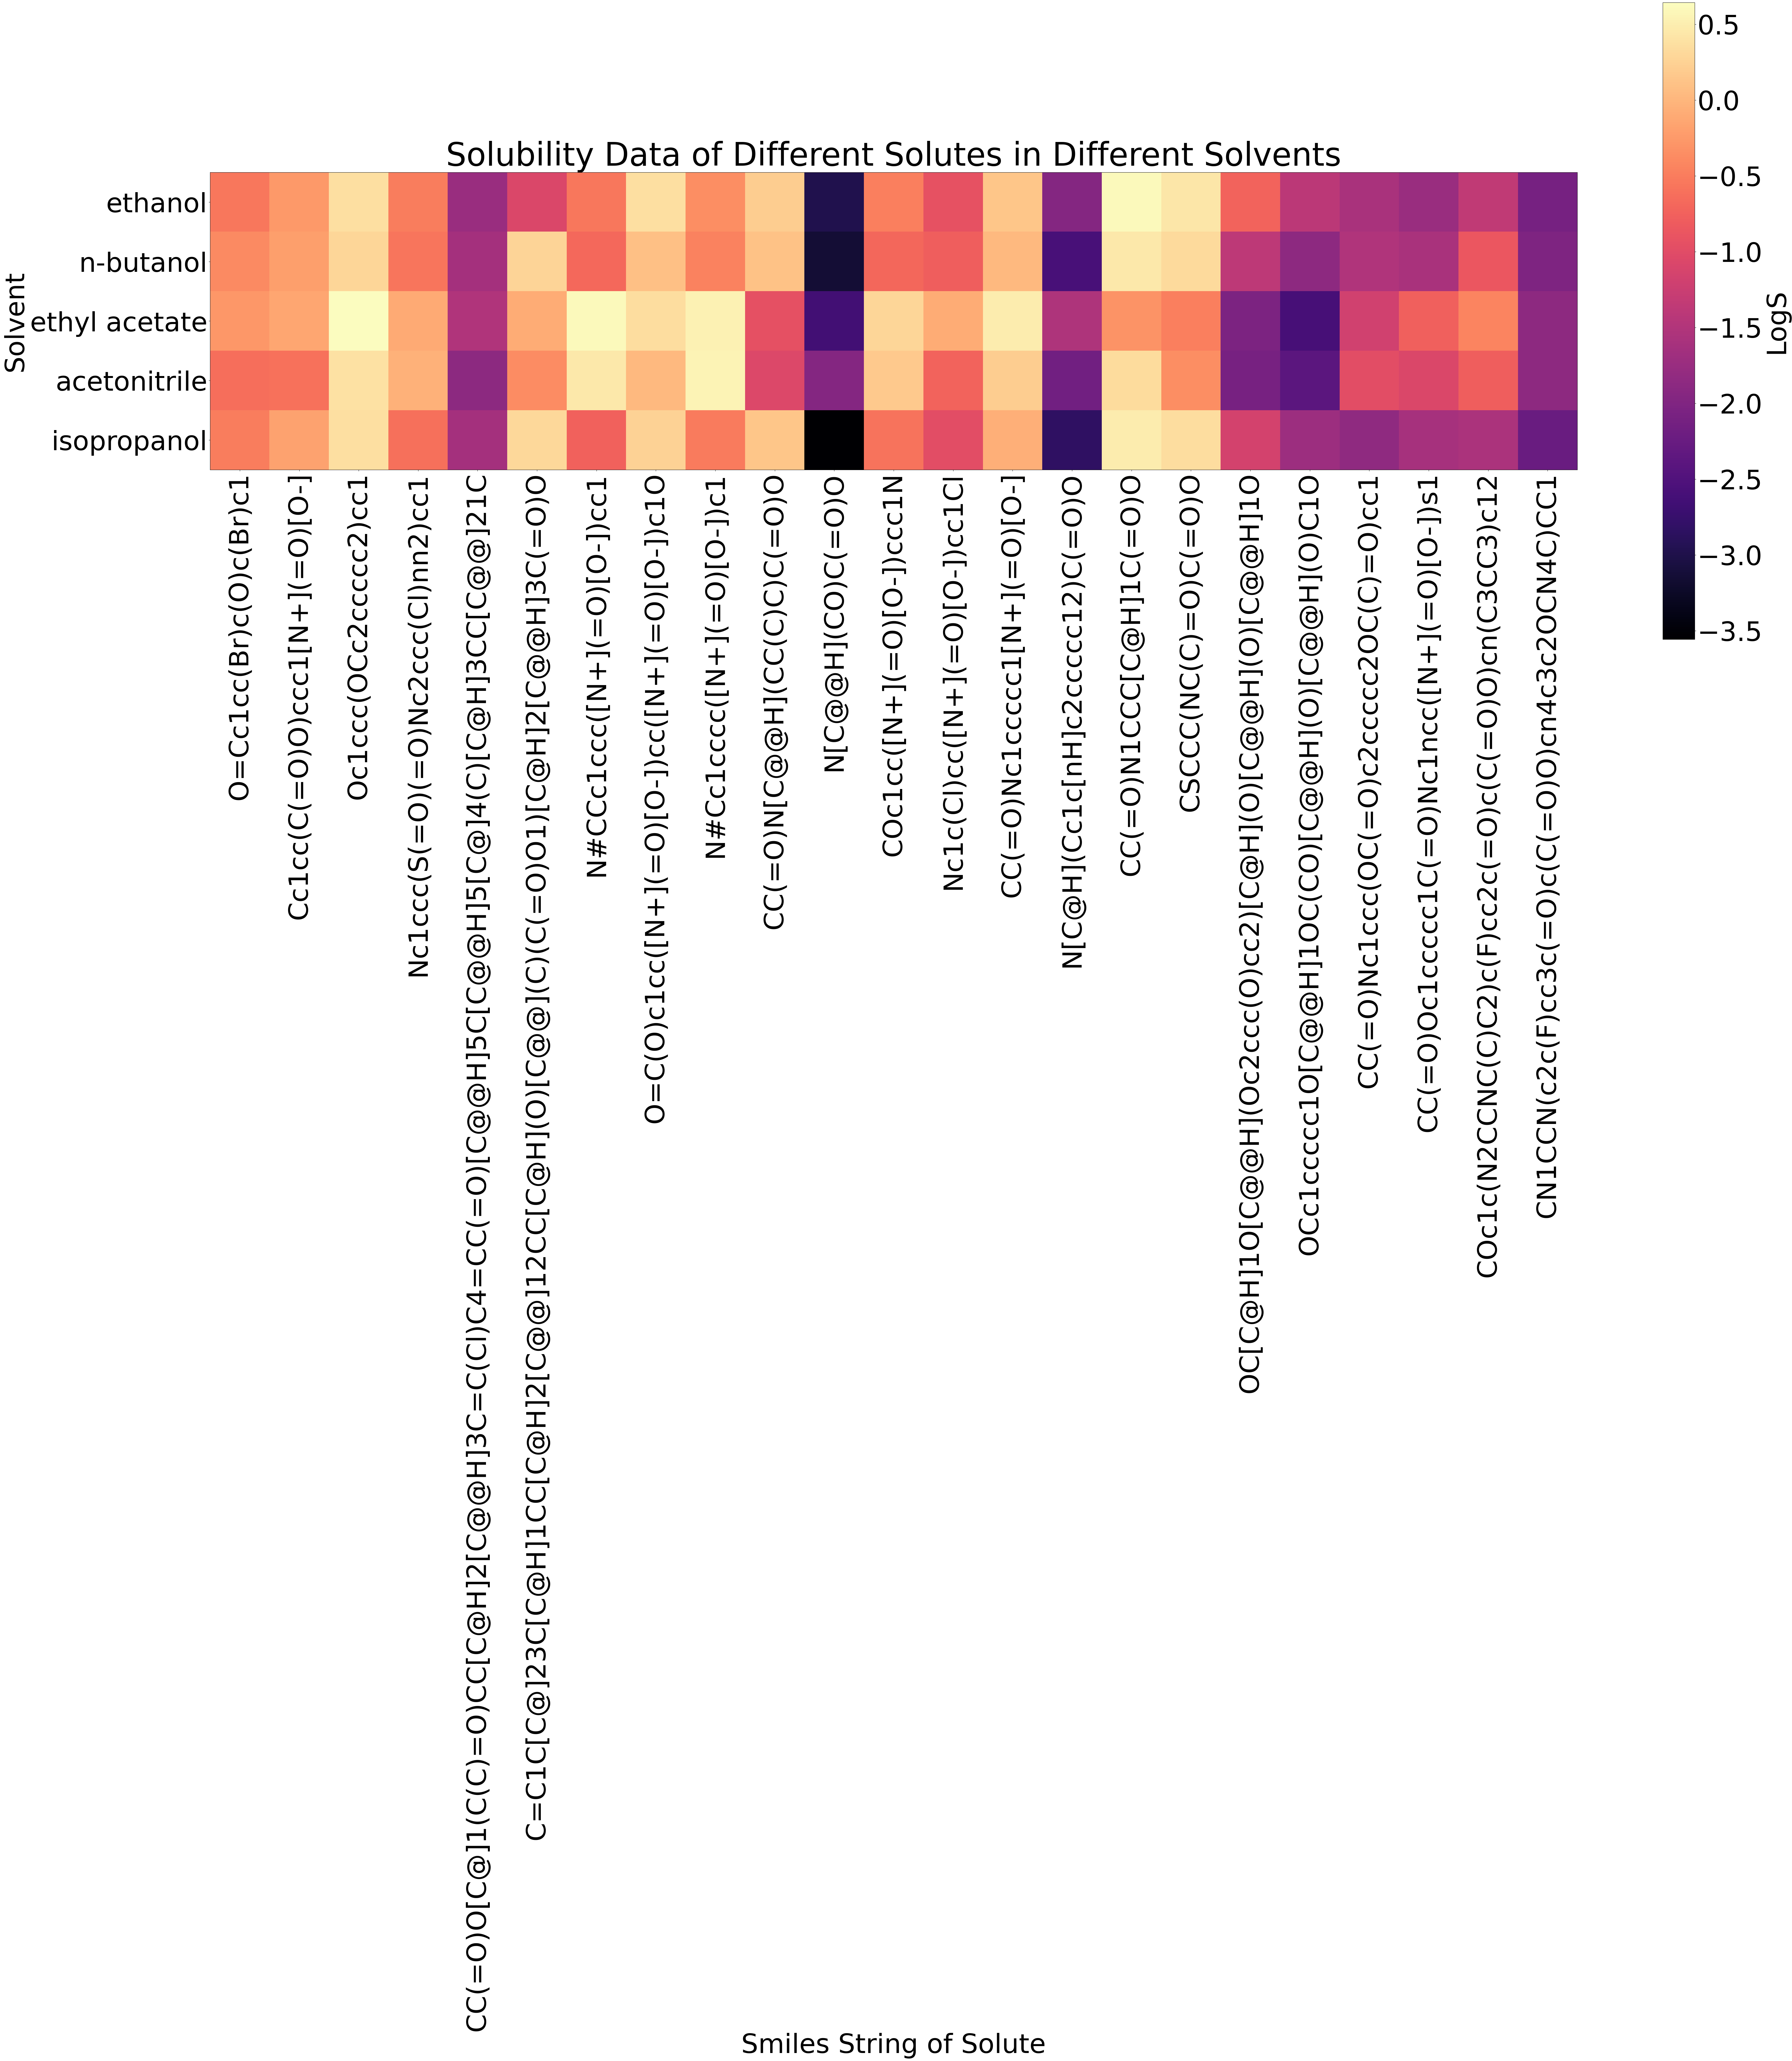

In [47]:
plt.rcParams.update({'font.size': 70})
plt.figure(figsize=(80, 30))
plt.imshow(soldynrange, cmap='magma')
plt.colorbar(label='LogS') 
plt.yticks([0, 1, 2, 3, 4], top5solvlst)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], soldynrange.keys(), rotation='vertical')
plt.ylabel('Solvent')
plt.xlabel('Smiles String of Solute')
plt.title('Solubility Data of Different Solutes in Different Solvents')
plt.show()